## TensorFlow 및 기타 라이브러리 가져오기

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## 데이터세트 로드하기

시작하려면 Fashon MNIST 데이터세트를 사용하여 기본 autoencoder를 훈련합니다. 이 데이터세트의 각 이미지는 28x28 픽셀입니다.

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4422102/4422102 [==============================] - 1s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [ ]:
latent_dim = 64

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

모델이 훈련되었으므로 테스트 세트에서 이미지를 인코딩 및 디코딩하여 테스트해 보겠습니다.

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

In [13]:
from scipy.ndimage import binary_dilation

def dilation(matrix, iterations=1):
    # binary_dilation
    dilated_matrix = binary_dilation(matrix, iterations=iterations)

    return dilated_matrix

이미지에 임의의 노이즈를 추가합니다.

In [14]:
noise_factor = 0.2
slope_error = dilation(np.diag(np.random.rand(28)), 2)

x_train_noisy = x_train + noise_factor * np.tile(slope_error, (x_train.shape[0], 1, 1))\
                * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * np.tile(slope_error, (x_test.shape[0], 1, 1))\
               * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

노이즈가 있는 이미지를 플롯합니다.


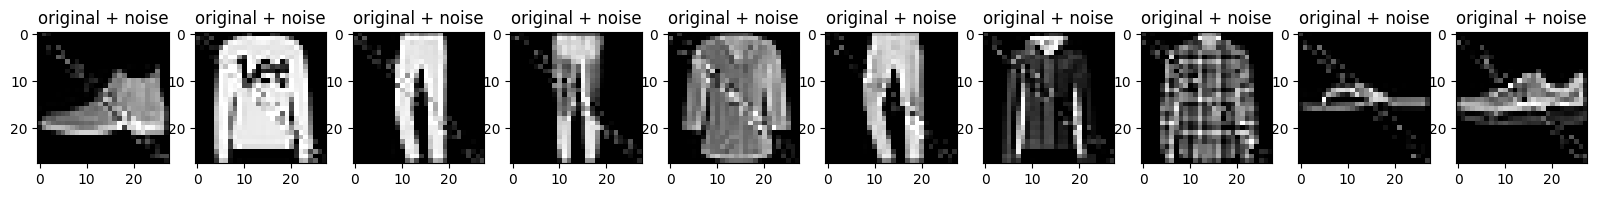

In [15]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### 컨볼루셔널 autoencoder 정의하기

이 예제에서는 <code>encoder</code>에 <a>Conv2D</a> 레이어를 사용하고 <code>decoder</code>에 <a>Conv2DTranspose</a> 레이어를 사용하여 컨볼루셔널 autoencoder를 훈련합니다.

In [16]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [17]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [18]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 21s 5ms/step - loss: 0.0147 - val_loss: 0.0056
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.00

encoder의 요약을 살펴보겠습니다. 이미지가 28x28에서 7x7로 어떻게 다운샘플링되는지 확인하세요.

In [19]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1320 (5.16 KB)
Trainable params: 1320 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


decoder는 이미지를 7x7에서 28x28로 다시 업샘플링합니다.

In [20]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 14, 14, 8)         584       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 16)        1168      
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1897 (7.41 KB)
Trainable params: 1897 (7.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


autoencoder에서 생성된 노이즈가 있는 이미지와 노이즈가 제거 된 이미지를 모두 플롯합니다.

In [21]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

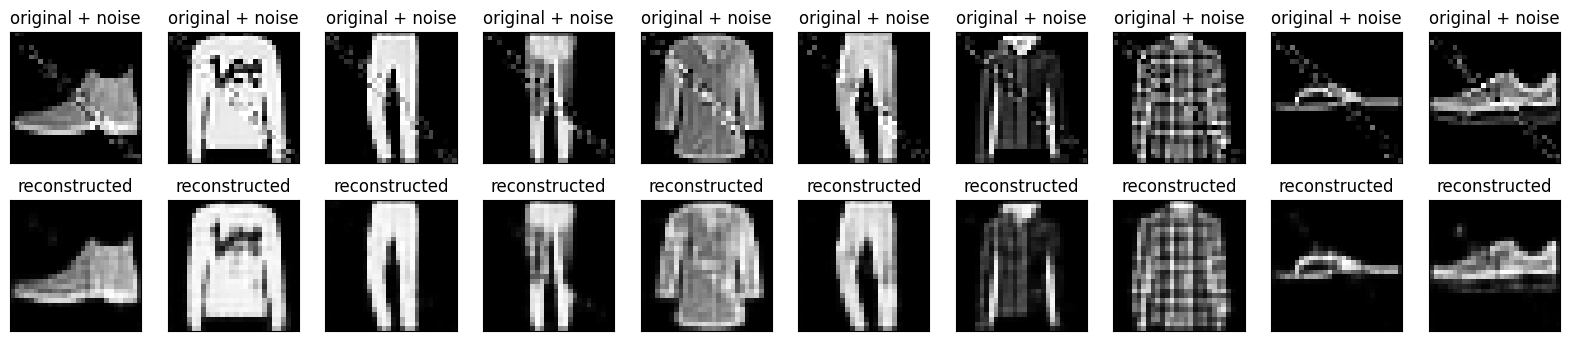

In [22]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()